In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Ellipse
import jupyterlab
from scipy.stats import multivariate_normal

In [2]:
cov_blue = np.vstack(([1/8,0],[0,1/4]))
mean_blue = np.array(([0,0]))
cov_red = np.vstack(([2,0],[0,1/2]))
mean_red = np.array(([1,2]))

In [3]:
N = 500

In [4]:
gaussian_blue = np.random.multivariate_normal(mean=mean_blue, cov=cov_blue, size=N)
gaussian_red = np.random.multivariate_normal(mean=mean_red, cov=cov_red, size=N)

/tmp/ipykernel_291/3133126334.py:1: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(gaussian_red[:,0], gaussian_red[:,1], 'bo', color='grey', marker='.', markersize=10)
/tmp/ipykernel_291/3133126334.py:1: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(gaussian_red[:,0], gaussian_red[:,1], 'bo', color='grey', marker='.', markersize=10)
/tmp/ipykernel_291/3133126334.py:2: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(gaussian_blue[:,0], gaussian_blue[:,1], 'bo', color='grey', marker='.', markersize=10)
/tmp/ipykernel_291/3133126334.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt str

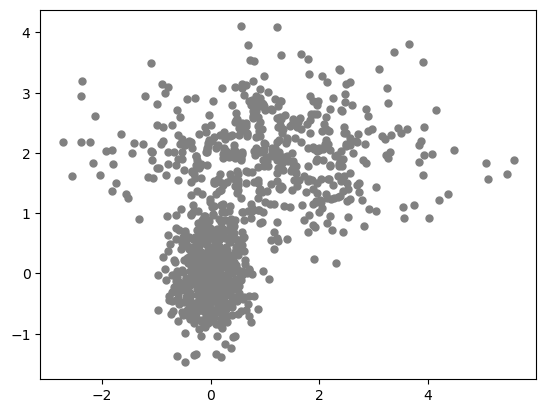

In [5]:
plt.plot(gaussian_red[:,0], gaussian_red[:,1], 'bo', color='grey', marker='.', markersize=10)
plt.plot(gaussian_blue[:,0], gaussian_blue[:,1], 'bo', color='grey', marker='.', markersize=10)

### Initializing in a 'separable' way

In [6]:
estimated_mean_0 = np.array((-2,-1))
estimated_cov_0 = np.eye(2)
estimated_mean_1 = np.array((4,4))
estimated_cov_1 = np.eye(2)

In [38]:
weighted_data = np.ones((2*N,5))

In [39]:
for i in range(N):
    weighted_data[i,0] = gaussian_blue[i,0]
    weighted_data[i,1] = gaussian_blue[i,1]
    weighted_data[N+i,0] = gaussian_red[i,0]
    weighted_data[N+i,1] = gaussian_red[i,1]

In [40]:
def unsupervised_gmm(initial_means, initial_cov, data, iterations):
    """a function to make unsupervised classification, by a GMM approach

    Parameters
    ----------------------------------
    initial means : dict
    a dictionary in which the initial means are the values

    initial cov : dict
    a dictionary in which the initial covariances are the values

    data : array-like object
    the data we want to analyze

    iterations : int
    the number of iterations wanted
    -------------------------------
    """
    n=0
    pi_gmm_0 = 1/2
    pi_gmm_1 = 1/2
    mu_hat_gmm_0 = initial_means['0']
    sigma_hat_gmm_0 = initial_cov['0']
    mu_hat_gmm_1 = initial_means['1']
    sigma_hat_gmm_1 = initial_cov['1']
    dim = data.shape[0]
    while n<=iterations:
        #first, compute the new weights
        for i in range(dim):
            weight_0 = multivariate_normal.pdf(x=data[i,0:2],
                                               mean=mu_hat_gmm_0,cov=sigma_hat_gmm_0)            
            weight_1 = multivariate_normal.pdf(x=data[i,0:2],
                                               mean=mu_hat_gmm_1,cov=sigma_hat_gmm_1)
            denom = (pi_gmm_0*weight_0)+(pi_gmm_1*weight_1)
            weighted_data[i,2] = (pi_gmm_0*weight_0)/denom
            weighted_data[i,3] = (pi_gmm_1*weight_1)/denom
        #update of the parameters
        #dictionnary would probably be more efficient
        pi_gmm_0 = np.mean(data[:,2])
        pi_gmm_1 = np.mean(data[:,3])
        sum_weights_0 = np.sum(data[:,2])
        sum_weights_1 = np.sum(data[:,3])
        mu_hat_gmm_0 = np.sum(data[:,0:2]*data[:,2].reshape((dim,1)),axis=0)/sum_weights_0
        mu_hat_gmm_1 = np.sum(data[:,0:2]*data[:,3].reshape((dim,1)),axis=0)/sum_weights_1
        sigma_hat_gmm_0 = np.zeros((2,2))
        sigma_hat_gmm_1 = np.zeros((2,2))
        for i in range(dim):
            sigma_hat_gmm_0 = sigma_hat_gmm_0 + np.matmul((data[i,0:2]-mu_hat_gmm_0).reshape((2,1)),(data[i,0:2]-mu_hat_gmm_0).reshape((1,2)))*data[i,2]
            sigma_hat_gmm_1 = sigma_hat_gmm_1 + np.matmul((data[i,0:2]-mu_hat_gmm_1).reshape((2,1)),(data[i,0:2]-mu_hat_gmm_1).reshape((1,2)))*data[i,3]
        sigma_hat_gmm_0 = sigma_hat_gmm_0/sum_weights_0
        sigma_hat_gmm_1 = sigma_hat_gmm_1/sum_weights_1
        n+=1
    for i in range(dim):
        if data[i,2]>data[i,3]:
            data[i,4] = 0
        else:
            data[i,4] = 1

    
    return data
 

In [41]:
test_means = {'0':estimated_mean_0,'1':estimated_mean_1}
test_cov = {'0':estimated_cov_0,'1':estimated_cov_1}

In [42]:
test_unsup = unsupervised_gmm(initial_means=test_means, initial_cov=test_cov,data=weighted_data,iterations=100)

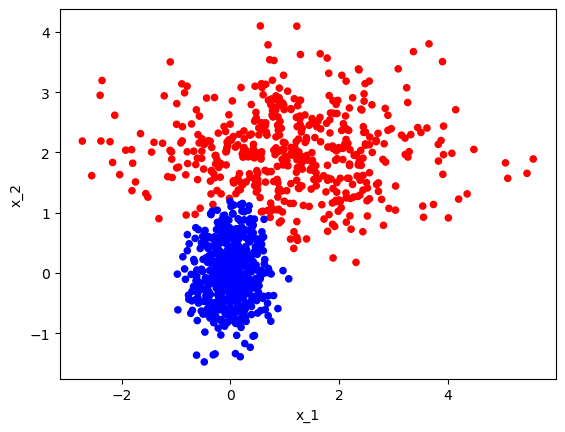

In [43]:
test_plot = pd.DataFrame(test_unsup)
test_plot.columns = ['x_1','x_2','w_0','w_1','label']
colors = {0:'blue', 1:'red'}
color_list = [colors[group] for group in test_plot['label']]
ax = test_plot.plot.scatter('x_1','x_2', c=color_list)

It works quite well